In [1]:
import pandas
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

In [2]:
"""
    Description: Function for running the K-means algorithm on data from a dataframe
    @param [Pandas DataFrame Object] df: The data frame with features
    @param [Boolean] centers: 'True' or 'False' for wanting to include cluster centers in the plot
    Return: [Array, Array] List of predicted leakages and list of actual leakages
"""


def Kmeans(df, centers):
    new_df = df.copy()
    leaks = list(df['isLeak']) 
    df = new_df.iloc[:, 2:] #Not including path and leakage-information in training
    n_clusters = 2 #number of clusters
    mod = KMeans(n_clusters=n_clusters , random_state=0) #creating model

    mod.fit(df) #training the model
    inertia = mod.inertia_
    predictions = mod.predict(df) #predicting/separating the dataset into two groups
    df['Predicted'] = predictions
    members_in_cluster = df.groupby(by='Predicted').count() #calculating the size of each cluster
    for cluster, i in enumerate(mod.cluster_centers_): #iterating though cluster centers 
        print("Cluster", str(cluster), ": Members = ", str(members_in_cluster.loc[cluster][0]))

    """plt.scatter(df['Rolloff'], df['Centroid'], c=mod.labels_, cmap='rainbow')
    if centers == True:
        plt.scatter(mod.cluster_centers_[:,0], mod.cluster_centers_[:,1], color='black')
    plt.show()"""
    return predictions, leaks, inertia
    

In [3]:
"""
    Description: Function for running the K-means algorithm on data from a dataframe
    @param [Array] predictions: List of predicted leakages values
    @param [Array] leaks: List of actual leakage values
    Return: [Array<Integer>] List containing the number of positives (leakages), negatives, 
    true positives (correctly predicted leakage), false positives, true negatives and false negatives
"""

def get_performance_score(predictions, leaks):

    cluster_0 = list(predictions).count(0)
    cluster_1 = list(predictions).count(1)

    no_leak_cluster_size = 0
    leak_cluster_size = 0

    leaks_in_0 = 0
    leaks_in_1 = 0
    
    for i in range(int(len(predictions))):
        if(predictions[i]==0 and leaks[i]==1):
            leaks_in_0 +=1
        if(predictions[i]==1 and leaks[i]==1):
            leaks_in_1 +=1
        if(leaks_in_0 > leaks_in_1):
            leak_cluster_size = cluster_0
            no_leak_cluster_size = cluster_1
            true_leakages = leaks_in_0
            false_leakages = leaks_in_1
        elif(leaks_in_0 < leaks_in_1):
            leak_cluster_size = cluster_1
            no_leak_cluster_size = cluster_0
            true_leakages = leaks_in_1
            false_leakages = leaks_in_0
    print('Size of leakage cluster: ', str(leak_cluster_size))
    print('Size of no leakage cluster: ', str(no_leak_cluster_size))
    print("Correctly Predicted Leakages: ", str(true_leakages))
    print("False Leakage Alerts: ", str(false_leakages))

    P = list(leaks).count(1)
    N = list(leaks).count(0)
    TP = true_leakages
    FP = leak_cluster_size - TP
    TN = no_leak_cluster_size - false_leakages
    FN = false_leakages
    
    return P, N, TP, FP, TN, FN

In [4]:
"""
    Description: The following five functions are for calculating evaluation metrics
    @param [Integer] P: Number of leakages
    @param [Integer] N: Number of non-leakages
    @param [Integer] TP: Number of correctly predicted leakages
    @param [Integer] TN: Number of correctly predicted non-leakages
    @param [Integer] FP: Number of falsesly predicted leakages
    @param [Integer] FN: Number of falsesly predicted non-leakages
    Return: [Float] The calculated score for Accuracy, Recall, Specificity, Precision and F1-score
"""

def Get_Accuracy(TP, TN, P, N):
    accuracy = (TP+TN)/(P+N)
    return accuracy

def Get_Recall(TP, FN):
    recall = TP/(TP+FN)
    return recall

def Get_Specificity(TN, FP):
    specificity = TN/(TN+FP)
    return specificity
        
def Get_Precision(TP, FP):
    precision = TP/(TP+FP)
    return precision
    
def Get_F1(Precision, Recall):
    F1_score = (2*Precision*Recall)/(Precision+Recall)
    return F1_score


In [5]:
"""
    This code requires action by the user. 
    The K-means algorithm is run with the different dataframes, and evaluation metrics and cluster sizes are printed.
"""

df_vent = pandas.read_csv('new_features_vent.csv')
df_tube = pandas.read_csv('new_features_tube.csv')
df_both = pandas.concat([df_vent, df_tube], axis=0, ignore_index=True)


"""
    Change the parameter of df to be either "df_tube", "df_vent" or "df_both"
"""
df = df_vent


"""
    Uncomment the two rows underneeth one by one to test K-means for the old and new feature combinations
"""
#df = df.drop(columns=['RMS 4-20kHz'])
df = df.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz', 'Centroid 4-8kHz', 'RMS 4-20kHz'])

predictions, leaks, inertia = Kmeans(df, centers=False)
[P, N, TP, FP, TN, FN] = get_performance_score(predictions, leaks)

print('Accuracy: ', str(Get_Accuracy(TP, TN, P, N)))
print('Recall: ', str(Get_Recall(TP, FN)))
print('Specificity: ', str(Get_Specificity(TN, FP)))
print('Precision: ', str(Get_Precision(TP, FP)))
print('F1-score: ', str(Get_F1(Get_Precision(TP, FP), Get_Recall(TP, FN))))
print('Inertia (SSE): ', inertia)

Cluster 0 : Members =  864
Cluster 1 : Members =  864
Size of leakage cluster:  864
Size of no leakage cluster:  864
Correctly Predicted Leakages:  432
False Leakage Alerts:  431
Accuracy:  0.5005787037037037
Recall:  0.5005793742757821
Specificity:  0.500578034682081
Precision:  0.5
F1-score:  0.5002895193977998
Inertia (SSE):  1220.8458538066516


In [6]:
#K-MEANS CLUSTERING WITH PICKING OUT FEATURES

"""
    Description: Function for selecting 3 features and save to a new dataframe
    @param [Pandas DataFrame Object] df: The data frame with all features
    @param [String] f1: The column-name of the first chosen feature from the original dataframe
    @param [String] f2: The column-name of the second chosen feature from the original dataframe
    @param [String] f3: The column-name of the third chosen feature from the original dataframe
    Return: [Pandas DataFrame Object] The new dataframe with only leakages-info and the three features
"""

def df_three_features(df, f1, f2, f3):
    leaks = df['isLeak']
    new_df = pandas.DataFrame()

    feature1 = df[f1]
    feature2 = df[f2]
    feature3 = df[f3]

    new_df['isLeak'] = leaks
    new_df[f1] = feature1
    new_df[f2] = feature2
    new_df[f3] = feature3

    return new_df

"""
    Description: Function for selecting 2 features and save to a new dataframe
    @param [Pandas DataFrame Object] df: The data frame with all features
    @param [String] f1: The column-name of the first chosen feature from the original dataframe
    @param [String] f2: The column-name of the second chosen feature from the original dataframe
    Return: [Pandas DataFrame Object] The new dataframe with only leakages-info and the two features
"""

def df_two_features(df, f1, f2):
    leaks = df['isLeak']
    new_df = pandas.DataFrame()

    feature1 = df[f1]
    feature2 = df[f2]

    new_df['isLeak'] = leaks
    new_df[f1] = feature1
    new_df[f2] = feature2

    return new_df

"""
    Description: Function for plotting data points by 3 features colored after predicted leakage value
    @param [Pandas DataFrame Object] df: The data frame with three features
    @param [Array] predictions: The list of predicted leakages
    Return: None, but shows 3D-plot 
"""

def plotting_clusters_3D(df, predictions, leaks):
    f1 = df.columns[1]
    f2 = df.columns[2]
    f3 = df.columns[3]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df[f1], df[f2], df[f3], c=leaks, cmap='rainbow')
    ax.set_title('Scatter plot using the top 3 features', fontsize=18)
    ax.set_xlabel(f1, fontsize=16)
    ax.set_ylabel(f2, fontsize=16)
    ax.set_zlabel(f3, fontsize=16)
    plt.show()
    
    

"""
    Description: Function for plotting data points by 2 features colored after predicted leakage value
    @param [Pandas DataFrame Object] df: The data frame with two features
    @param [Array] predictions: The list of predicted leakages
    Return: None, but shows 2D-plot 
"""

def plotting_clusters_2D(df, predictions, leaks):
    f1 = df.columns[1]
    f2 = df.columns[2]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    ax.scatter(df[f1], df[f2], c=predictions, cmap='tab10')
    ax.set_title('Scatter plot using features '+f1+' and '+f2)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    plt.show()


Cluster 0 : Members =  2235
Cluster 1 : Members =  1413


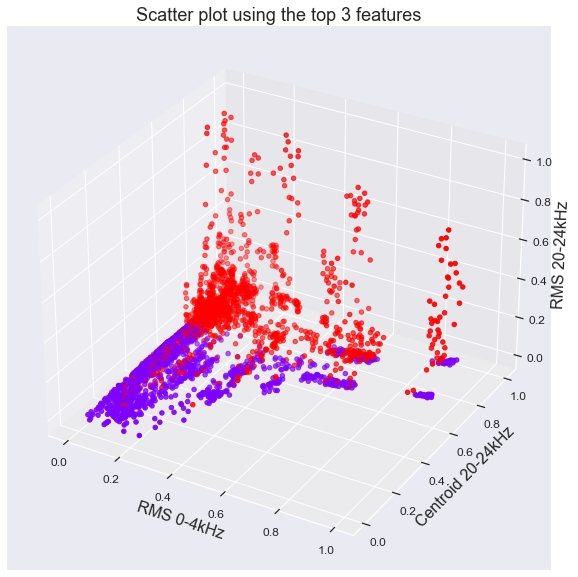

Size of leakage cluster:  2235
Size of no leakage cluster:  1413
Correctly Predicted Leakages:  1703
False Leakage Alerts:  121
Accuracy:  0.8209978070175439
Recall:  0.9336622807017544
Specificity:  0.7083333333333334
Precision:  0.7619686800894855
F1-score:  0.8391229366839124


In [218]:
"""
    This part of the code requires action by the user. 
    The user needs to define which feature to use by changing the feature names for f1, f2 and f3.
"""


df_tube = pandas.read_csv('new_features_tube.csv')
df_vent = pandas.read_csv('new_features_vent.csv')
df_both = pandas.concat([df_vent, df_tube], axis=0, ignore_index=True)

df = df_both

f1, f2, f3 = 'RMS 0-4kHz', 'Centroid 20-24kHz', 'RMS 20-24kHz'
df = df_three_features(df, f1, f2, f3)
predictions, leaks, inertia = Kmeans(df, centers=False)
plotting_clusters_3D(df, predictions, leaks)

"""
    By uncommenting the code below and defining the two features for f1 and f2, the user can display a 2D-plot
"""

"""df_tube = pandas.read_csv('new_features_tube.csv')
df_vent = pandas.read_csv('new_features_vent.csv')
df = pandas.concat([df_vent, df_tube], axis=0, ignore_index=True)
f1, f2 = 'PSD >20kHz', 'MAX_AMP >20kHz'
df = df_two_features(df, f1, f2)
predictions, leaks, inertia = Kmeans(df, centers=False)
plotting_clusters_2D(df, predictions)"""

P, N, TP, FP, TN, FN = get_performance_score(predictions, leaks)
print('Accuracy: ', str(Get_Accuracy(TP, TN, P, N)))
print('Recall: ', str(Get_Recall(TP, FN)))
print('Specificity: ', str(Get_Specificity(TN, FP)))
print('Precision: ', str(Get_Precision(TP, FP)))
print('F1-score: ', str(Get_F1(Get_Precision(TP, FP),Get_Recall(TP, FN))))

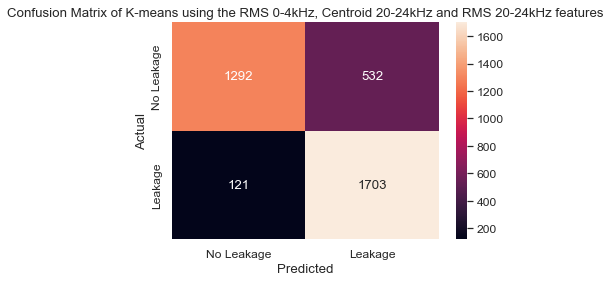

In [219]:
ax = plt.subplot()
sns.heatmap(np.array([[TN, FP], [FN, TP]]), annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual') 
ax.set_title('Confusion Matrix of K-means using the '+f1+', '+f2+' and ' +f3+ ' features')
ax.xaxis.set_ticklabels(['No Leakage', 'Leakage']); ax.yaxis.set_ticklabels(['No Leakage', 'Leakage'])
plt.show()

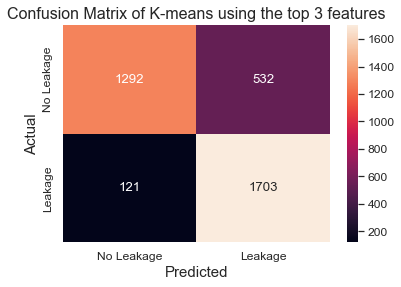

In [220]:
ax = plt.subplot()
sns.set(font_scale=1.1)
sns.heatmap(np.array([[TN, FP], [FN, TP]]), annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted', fontdict={'size':'15'}); ax.set_ylabel('Actual', fontdict={'size':'15'}) 
ax.set_title('Confusion Matrix of K-means using the top 3 features', fontsize='16')
ax.xaxis.set_ticklabels(['No Leakage', 'Leakage']); ax.yaxis.set_ticklabels(['No Leakage', 'Leakage'])
plt.show()